In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from shapely.geometry import Point, Polygon
from tqdm import tqdm, trange
import h5py
import logging

from herbie import Herbie
from toolbox import EasyMap, pc
from paint.standard2 import cm_dpt, cm_pcp, cm_rh, cm_tmp, cm_wind

ERROR 1: PROJ: proj_create_from_database: Open of /global/homes/l/lizh142/.conda/envs/atsww/share/proj failed


In [2]:
days_months = {1:31, 2:28, 3:31, 4:30, 5:31, 6:30, 7:31, 8:31, 9:30, 10:31, 11:30, 12:31}
np.cumsum([0,0]+list(days_months.values()))

array([  0,   0,  31,  59,  90, 120, 151, 181, 212, 243, 273, 304, 334,
       365])

In [3]:
plt.style.use('ggplot')
pd.options.display.max_columns = None
pd.options.display.max_rows = 999

# Define domains

In [4]:
def wa(x):
    return x[-200:-50,200:450]

In [5]:
def yrb(x):
    return x[-183:-112,287:345]

In [6]:
def il(x):
    return x[350:-250,850:-450]

In [7]:
def mkz(x):
    return x[-246:-217,222:262]

In [8]:
yrb_wbd = np.loadtxt('./xyz_csv/yrb_wbd.xyz')
yrb_box = np.array([[np.min(yrb_wbd[:,0]), np.min(yrb_wbd[:,1])], 
                    [np.min(yrb_wbd[:,0]), np.max(yrb_wbd[:,1])], 
                    [np.max(yrb_wbd[:,0]), np.max(yrb_wbd[:,1])], 
                    [np.max(yrb_wbd[:,0]), np.min(yrb_wbd[:,1])]])

In [9]:
mkz_wbd = np.loadtxt('./xyz_csv/mkz_wbd.xyz')
mkz_box = np.array([[np.min(mkz_wbd[:,0]), np.min(mkz_wbd[:,1])], 
                    [np.min(mkz_wbd[:,0]), np.max(mkz_wbd[:,1])], 
                    [np.max(mkz_wbd[:,0]), np.max(mkz_wbd[:,1])], 
                    [np.max(mkz_wbd[:,0]), np.min(mkz_wbd[:,1])]])

# Single frame visualization

## Find latest

In [10]:
now = pd.Timestamp.utcnow().floor("1h").tz_localize(None)
dates = pd.date_range(now, periods=6, freq="-1H")
dates

/tmp/ipykernel_2326896/1831983551.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(now, periods=6, freq="-1H")


DatetimeIndex(['2024-10-08 23:00:00', '2024-10-08 22:00:00',
               '2024-10-08 21:00:00', '2024-10-08 20:00:00',
               '2024-10-08 19:00:00', '2024-10-08 18:00:00'],
              dtype='datetime64[ns]', freq='-1h')

In [11]:
# Find first existing Herbie object
for latest in dates:
    H = Herbie(latest, model="hrrr")
    if H.grib:
        break

💔 Did not find ┊ model=hrrr ┊ product=sfc ┊ 2024-Oct-08 23:00 UTC F00
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2024-Oct-08 22:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


## Download latest data

In [12]:
time = latest  # "2018-04-14 19:00:00" 

In [13]:
forecast = 1
if forecast:
    postfix = f'{forecast} hour fcst'
else:
    postfix = 'anl'

In [14]:
H = Herbie(
    time,
    model="hrrr",
    product="sfc", # 'sfc', 'prs', 'nat', 'subh'
    fxx=forecast,
)

✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2024-Oct-08 22:00 UTC F01 ┊ GRIB2 @ aws ┊ IDX @ aws


In [15]:
# def is_point_inside_polygon(point_coords, polygon_coords):
#     point = Point(point_coords[0], point_coords[1])
#     polygon = Polygon(polygon_coords)
#     return point.within(polygon)
# if os.path.isfile('yrb_box_index.txt'):
#     lon_index, lat_index = np.loadtxt('yrb_box_index.txt')[:, 0], np.loadtxt('yrb_box_index.txt')[:, 1]
# else:
#     lon_index, lat_index = [], []
#     for i in tqdm(range(t2m.longitude.shape[0])):
#         for j in range(t2m.longitude.shape[1]):
#             point_coords = np.array((t2m.longitude.values[i, j]-360, t2m.latitude.values[i, j]))
#             if is_point_inside_polygon(point_coords, yrb_box):
#                 lon_index.append(i)
#                 lat_index.append(j)
#     np.savetxt('yrb_box_index.txt', np.stack([lon_index, lat_index]).T, fmt='%.0f')
# def yrb(x):
#     return x[lon_index, lat_index]

## Check the inventory

In [16]:
H.inventory()

,grib_message,start_byte,end_byte,range,reference_time,valid_time,variable,level,forecast_time,search_this
0,1,0,268128.0,0-268128,2024-10-08 22:00:00,2024-10-08 23:00:00,REFC,entire atmosphere,1 hour fcst,:REFC:entire atmosphere:1 hour fcst
1,2,268129,438367.0,268129-438367,2024-10-08 22:00:00,2024-10-08 23:00:00,RETOP,cloud top,1 hour fcst,:RETOP:cloud top:1 hour fcst
2,3,438368,760681.0,438368-760681,2024-10-08 22:00:00,2024-10-08 23:00:00,var discipline=0 center=7 local_table=1 parmca...,entire atmosphere,1 hour fcst,:var discipline=0 center=7 local_table=1 parmc...
3,4,760682,965473.0,760682-965473,2024-10-08 22:00:00,2024-10-08 23:00:00,VIL,entire atmosphere,1 hour fcst,:VIL:entire atmosphere:1 hour fcst
4,5,965474,2362359.0,965474-2362359,2024-10-08 22:00:00,2024-10-08 23:00:00,VIS,surface,1 hour fcst,:VIS:surface:1 hour fcst
5,6,2362360,2538106.0,2362360-2538106,2024-10-08 22:00:00,2024-10-08 23:00:00,REFD,1000 m above ground,1 hour fcst,:REFD:1000 m above ground:1 hour fcst
6,7,2538107,2667859.0,2538107-2667859,2024-10-08 22:00:00,2024-10-08 23:00:00,REFD,4000 m above ground,1 hour fcst,:REFD:4000 m above ground:1 hour fcst
7,8,2667860,2802017.0,2667860-2802017,2024-10-08 22:00:00,2024-10-08 23:00:00,REFD,263 K level,1 hour fcst,:REFD:263 K level:1 hour fcst
8,9,2802018,3937827.0,2802018-3937827,2024-10-08 22:00:00,2024-10-08 23:00:00,GUST,surface,1 hour fcst,:GUST:surface:1 hour fcst
9,10,3937828,4676913.0,3937828-4676913,2024-10-08 22:00:00,2024-10-08 23:00:00,UGRD,250 mb,1 hour fcst,:UGRD:250 mb:1 hour fcst


In [17]:
H.inventory(searchString="SOIL")

/tmp/ipykernel_2326896/2789444685.py:1: DeprecationWarning: The argument `searchString` was renamed `search`. Please update your scripts.
  H.inventory(searchString="SOIL")


,grib_message,start_byte,end_byte,range,reference_time,valid_time,variable,level,forecast_time,search_this


In [18]:
H.inventory(searchString="PRATE")

/tmp/ipykernel_2326896/169576137.py:1: DeprecationWarning: The argument `searchString` was renamed `search`. Please update your scripts.
  H.inventory(searchString="PRATE")


,grib_message,start_byte,end_byte,range,reference_time,valid_time,variable,level,forecast_time,search_this
82,83,58462178,58512071.0,58462178-58512071,2024-10-08 22:00:00,2024-10-08 23:00:00,PRATE,surface,1 hour fcst,:PRATE:surface:1 hour fcst


In [19]:
H.inventory(searchString="APCP")

/tmp/ipykernel_2326896/1869246255.py:1: DeprecationWarning: The argument `searchString` was renamed `search`. Please update your scripts.
  H.inventory(searchString="APCP")


,grib_message,start_byte,end_byte,range,reference_time,valid_time,variable,level,forecast_time,search_this
83,84,58512072,58760983.0,58512072-58760983,2024-10-08 22:00:00,2024-10-08 23:00:00,APCP,surface,0-1 hour acc fcst,:APCP:surface:0-1 hour acc fcst


In [20]:
H.inventory(searchString="DSWRF")

/tmp/ipykernel_2326896/1122077544.py:1: DeprecationWarning: The argument `searchString` was renamed `search`. Please update your scripts.
  H.inventory(searchString="DSWRF")


,grib_message,start_byte,end_byte,range,reference_time,valid_time,variable,level,forecast_time,search_this
122,123,85269664,86700606.0,85269664-86700606,2024-10-08 22:00:00,2024-10-08 23:00:00,DSWRF,surface,1 hour fcst,:DSWRF:surface:1 hour fcst


In [21]:
H.inventory(searchString="RH")

/tmp/ipykernel_2326896/3988777923.py:1: DeprecationWarning: The argument `searchString` was renamed `search`. Please update your scripts.
  H.inventory(searchString="RH")


,grib_message,start_byte,end_byte,range,reference_time,valid_time,variable,level,forecast_time,search_this
74,75,47854429,49310984.0,47854429-49310984,2024-10-08 22:00:00,2024-10-08 23:00:00,RH,2 m above ground,1 hour fcst,:RH:2 m above ground:1 hour fcst
139,140,112918566,113644481.0,112918566-113644481,2024-10-08 22:00:00,2024-10-08 23:00:00,RH,0C isotherm,1 hour fcst,:RH:0C isotherm:1 hour fcst
142,143,114990396,115715830.0,114990396-115715830,2024-10-08 22:00:00,2024-10-08 23:00:00,RH,highest tropospheric freezing level,1 hour fcst,:RH:highest tropospheric freezing level:1 hour...
163,164,138678890,139860926.0,138678890-139860926,2024-10-08 22:00:00,2024-10-08 23:00:00,RHPW,entire atmosphere,1 hour fcst,:RHPW:entire atmosphere:1 hour fcst


In [22]:
H.inventory(searchString="TMP")

/tmp/ipykernel_2326896/2841818588.py:1: DeprecationWarning: The argument `searchString` was renamed `search`. Please update your scripts.
  H.inventory(searchString="TMP")


,grib_message,start_byte,end_byte,range,reference_time,valid_time,variable,level,forecast_time,search_this
14,15,7486236,8039162.0,7486236-8039162,2024-10-08 22:00:00,2024-10-08 23:00:00,TMP,500 mb,1 hour fcst,:TMP:500 mb:1 hour fcst
19,20,10879172,11434420.0,10879172-11434420,2024-10-08 22:00:00,2024-10-08 23:00:00,TMP,700 mb,1 hour fcst,:TMP:700 mb:1 hour fcst
25,26,15335082,15908064.0,15335082-15908064,2024-10-08 22:00:00,2024-10-08 23:00:00,TMP,850 mb,1 hour fcst,:TMP:850 mb:1 hour fcst
29,30,18245543,18823962.0,18245543-18823962,2024-10-08 22:00:00,2024-10-08 23:00:00,TMP,925 mb,1 hour fcst,:TMP:925 mb:1 hour fcst
33,34,21227460,21831676.0,21227460-21831676,2024-10-08 22:00:00,2024-10-08 23:00:00,TMP,1000 mb,1 hour fcst,:TMP:1000 mb:1 hour fcst
63,64,40303416,41559398.0,40303416-41559398,2024-10-08 22:00:00,2024-10-08 23:00:00,TMP,surface,1 hour fcst,:TMP:surface:1 hour fcst
70,71,42917717,44125125.0,42917717-44125125,2024-10-08 22:00:00,2024-10-08 23:00:00,TMP,2 m above ground,1 hour fcst,:TMP:2 m above ground:1 hour fcst


## Visualization

### Temperature (2 m above ground)

In [23]:
t2m = H.xarray(":TMP:2 m above ground:"+postfix, remove_grib=False)

👨🏻‍🏭 Created directory: [/pscratch/sd/l/lizh142/hrrr/data/hrrr/20241008]


#### CONUS

Text(1.0, 1.0, '2 metre temperature')

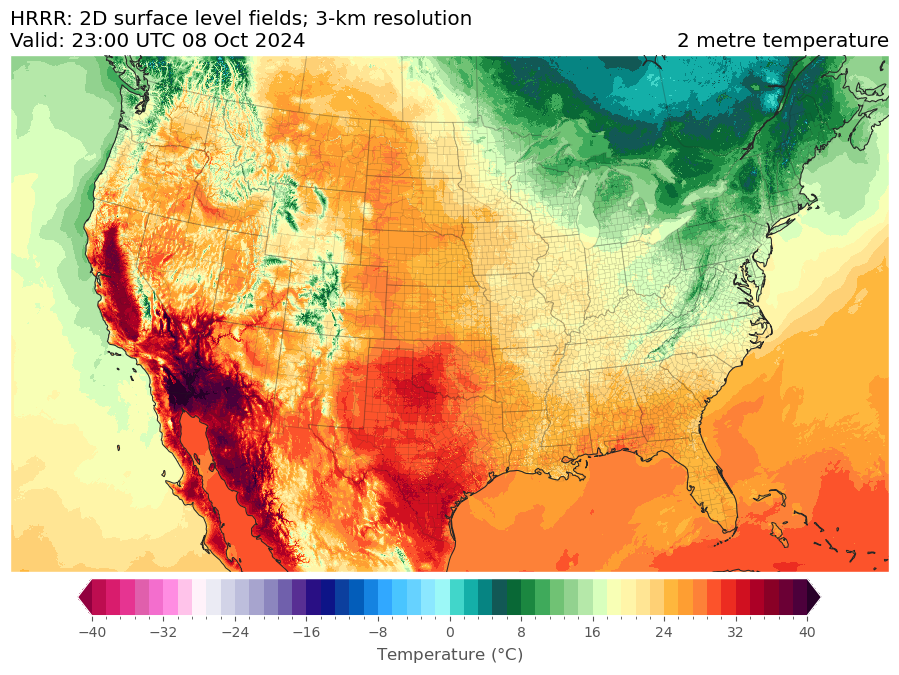

In [24]:
ax = EasyMap("50m", crs=t2m.herbie.crs, figsize=(12, 8)).STATES().OCEAN().LAND().COUNTIES().ax

p = ax.pcolormesh(
    t2m.longitude,
    t2m.latitude,
    t2m.t2m-273.15,
    transform=pc,
    **cm_tmp(units="C", vmin=-40, vmax=40).cmap_kwargs,
)
plt.colorbar(
    p,
    ax=ax,
    orientation="horizontal",
    pad=0.01,
    shrink=0.8,
    **cm_tmp(units="C", vmin=-40, vmax=40).cbar_kwargs,
)

ax.set_title(
    f"{t2m.model.upper()}: {H.product_description}\nValid: {t2m.valid_time.dt.strftime('%H:%M UTC %d %b %Y').item()}",
    loc="left",
)
ax.set_title(t2m.t2m.GRIB_name, loc="right")

In [25]:
# t2m = t2m.metpy.assign_crs(
#     dict(
#         grid_mapping_name="lambert_conformal_conic",
#         standard_parallel=(25, 60),
#         latitude_of_projection_origin=42.5,
#         longitude_of_central_meridian=260,
#     )
# )
# t2m

In [26]:
# t2m.gribfile_projection

#### Washington and YRB

Text(1.0, 1.0, '2 metre temperature')

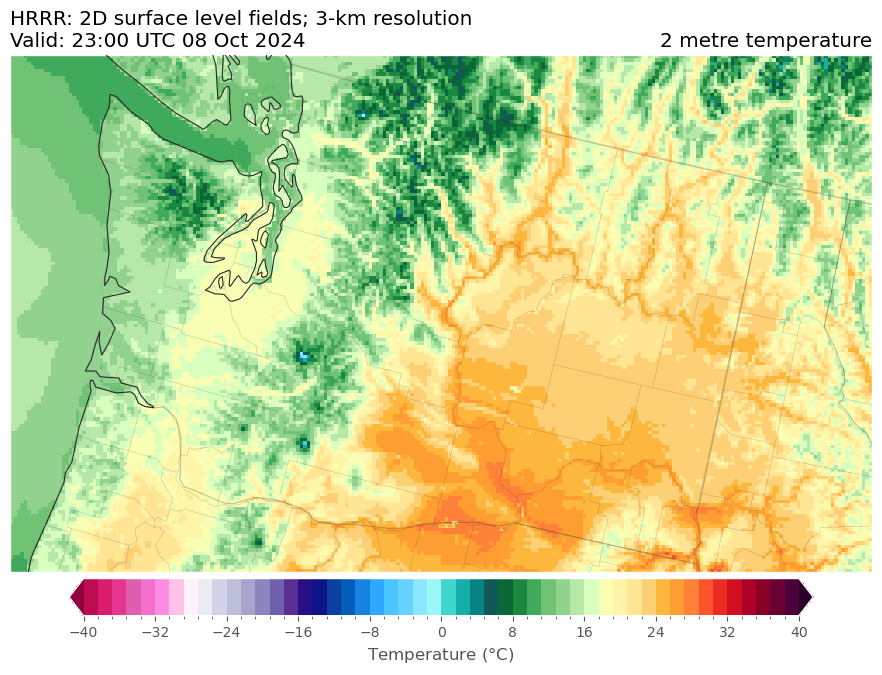

In [27]:
ax = EasyMap("50m", crs=t2m.herbie.crs, figsize=(12, 8)).STATES().OCEAN().LAND().COUNTIES().ax

p = ax.pcolormesh(
    wa(t2m.longitude),
    wa(t2m.latitude),
    wa(t2m.t2m)-273.15,
    transform=pc,
    **cm_tmp(units="C", vmin=-40, vmax=40).cmap_kwargs,
)
plt.colorbar(
    p,
    ax=ax,
    orientation="horizontal",
    pad=0.01,
    shrink=0.8,
    **cm_tmp(units="C", vmin=-40, vmax=40).cbar_kwargs,
)

ax.set_title(
    f"{t2m.model.upper()}: {H.product_description}\nValid: {t2m.valid_time.dt.strftime('%H:%M UTC %d %b %Y').item()}",
    loc="left",
)
ax.set_title(t2m.t2m.GRIB_name, loc="right")

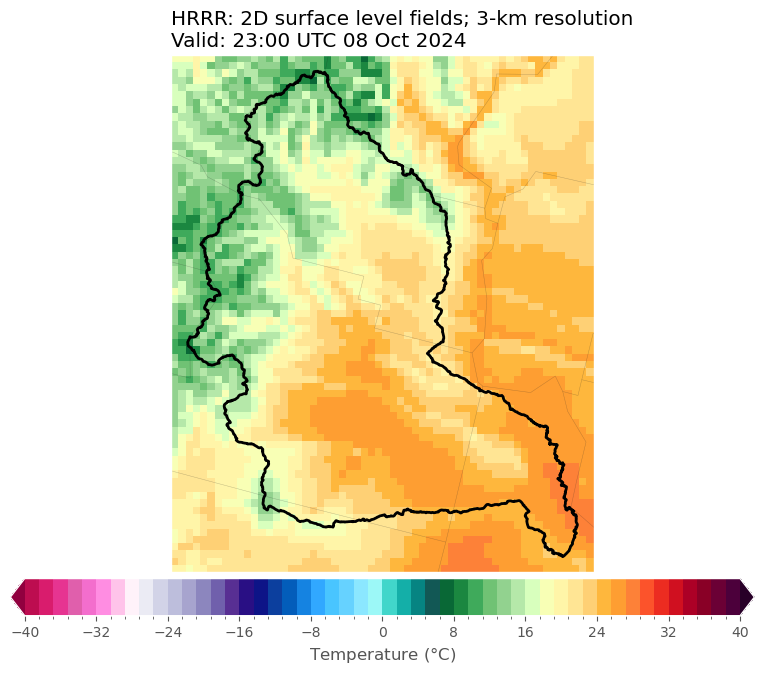

In [28]:
ax = EasyMap("50m", crs=t2m.herbie.crs, figsize=(12, 8)).STATES().OCEAN().LAND().COUNTIES().ax

p = ax.pcolormesh(
    yrb(t2m.longitude),
    yrb(t2m.latitude),
    yrb(t2m.t2m)-273.15,
    transform=pc,
    **cm_tmp(units="C", vmin=-40, vmax=40).cmap_kwargs,
)
plt.colorbar(
    p,
    ax=ax,
    orientation="horizontal",
    pad=0.01,
    shrink=0.8,
    **cm_tmp(units="C", vmin=-40, vmax=40).cbar_kwargs,
)

ax.set_title(
    f"{t2m.model.upper()}: {H.product_description}\nValid: {t2m.valid_time.dt.strftime('%H:%M UTC %d %b %Y').item()}",
    loc="left",
)
# ax.set_title(t2m.t2m.GRIB_name, loc="right")

ax.plot(yrb_wbd[:,0]+360, yrb_wbd[:,1], 'k', lw=2, transform=pc)

#### Mckenzie

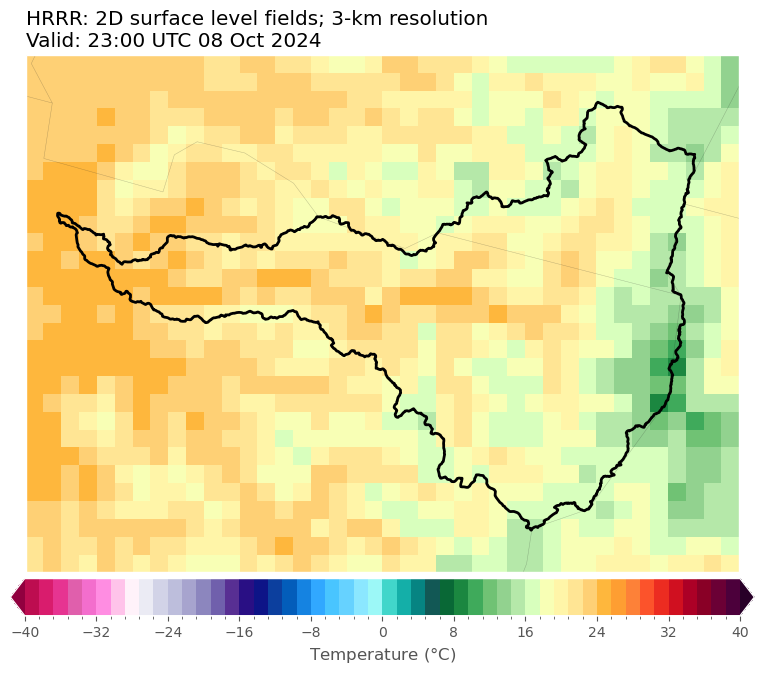

In [29]:
ax = EasyMap("50m", crs=t2m.herbie.crs, figsize=(12, 8)).STATES().OCEAN().LAND().COUNTIES().ax

p = ax.pcolormesh(
    mkz(t2m.longitude),
    mkz(t2m.latitude),
    mkz(t2m.t2m)-273.15,
    transform=pc,
    **cm_tmp(units="C", vmin=-40, vmax=40).cmap_kwargs,
)
plt.colorbar(
    p,
    ax=ax,
    orientation="horizontal",
    pad=0.01,
    shrink=0.8,
    **cm_tmp(units="C", vmin=-40, vmax=40).cbar_kwargs,
)

ax.set_title(
    f"{t2m.model.upper()}: {H.product_description}\nValid: {t2m.valid_time.dt.strftime('%H:%M UTC %d %b %Y').item()}",
    loc="left",
)
# ax.set_title(t2m.t2m.GRIB_name, loc="right")

ax.plot(mkz_wbd[:,0]+360, mkz_wbd[:,1], 'k', lw=2, transform=pc)

### Temperature (surface)

In [30]:
t = H.xarray(":TMP:surface:"+postfix, remove_grib=False)

#### CONUS

Text(1.0, 1.0, 'Temperature')

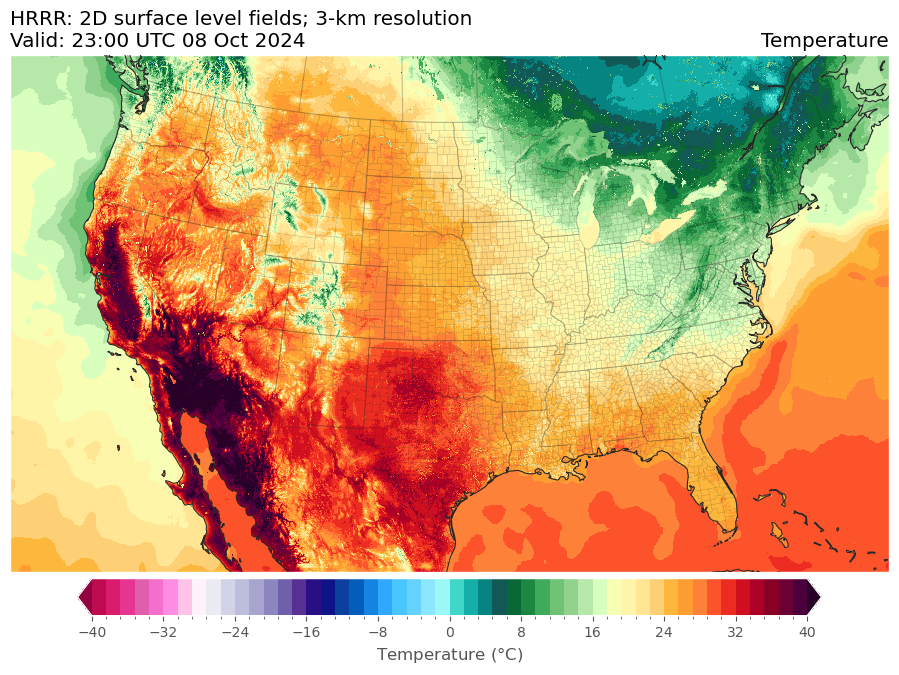

In [31]:
ax = EasyMap("50m", crs=t.herbie.crs, figsize=(12, 8)).STATES().OCEAN().LAND().COUNTIES().ax

p = ax.pcolormesh(
    t.longitude,
    t.latitude,
    t.t-273.15,
    transform=pc,
    **cm_tmp(units="C", vmin=-40, vmax=40).cmap_kwargs,
)
plt.colorbar(
    p,
    ax=ax,
    orientation="horizontal",
    pad=0.01,
    shrink=0.8,
    **cm_tmp(units="C", vmin=-40, vmax=40).cbar_kwargs,
)

ax.set_title(
    f"{t.model.upper()}: {H.product_description}\nValid: {t.valid_time.dt.strftime('%H:%M UTC %d %b %Y').item()}",
    loc="left",
)
ax.set_title(t.t.GRIB_name, loc="right")

#### Washington and YRB

Text(1.0, 1.0, 'Temperature')

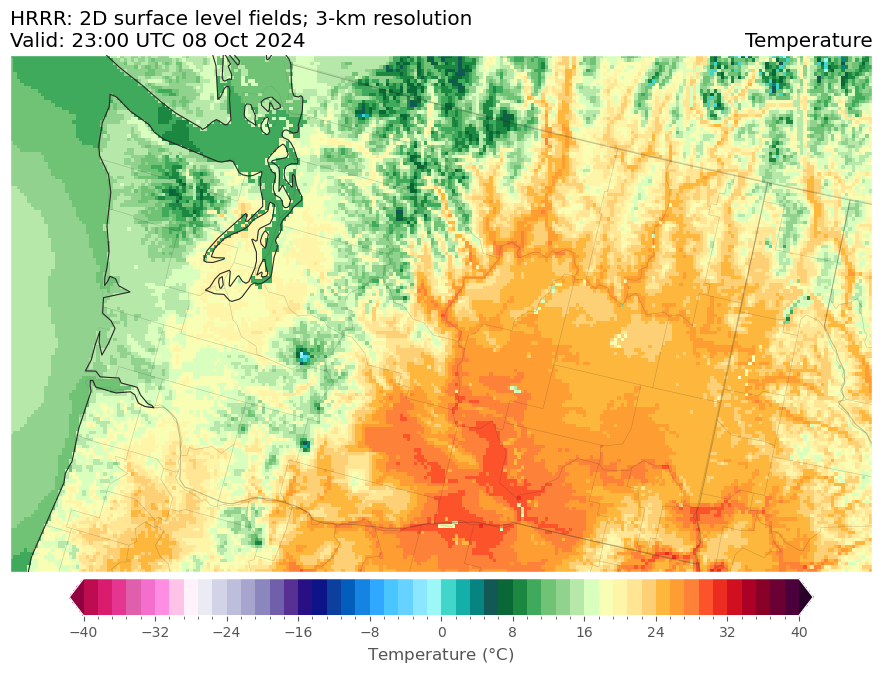

In [32]:
ax = EasyMap("50m", crs=t.herbie.crs, figsize=(12, 8)).STATES().OCEAN().LAND().COUNTIES().ax

p = ax.pcolormesh(
    wa(t.longitude),
    wa(t.latitude),
    wa(t.t)-273.15,
    transform=pc,
    **cm_tmp(units="C", vmin=-40, vmax=40).cmap_kwargs,
)
plt.colorbar(
    p,
    ax=ax,
    orientation="horizontal",
    pad=0.01,
    shrink=0.8,
    **cm_tmp(units="C", vmin=-40, vmax=40).cbar_kwargs,
)

ax.set_title(
    f"{t.model.upper()}: {H.product_description}\nValid: {t.valid_time.dt.strftime('%H:%M UTC %d %b %Y').item()}",
    loc="left",
)
ax.set_title(t.t.GRIB_name, loc="right")

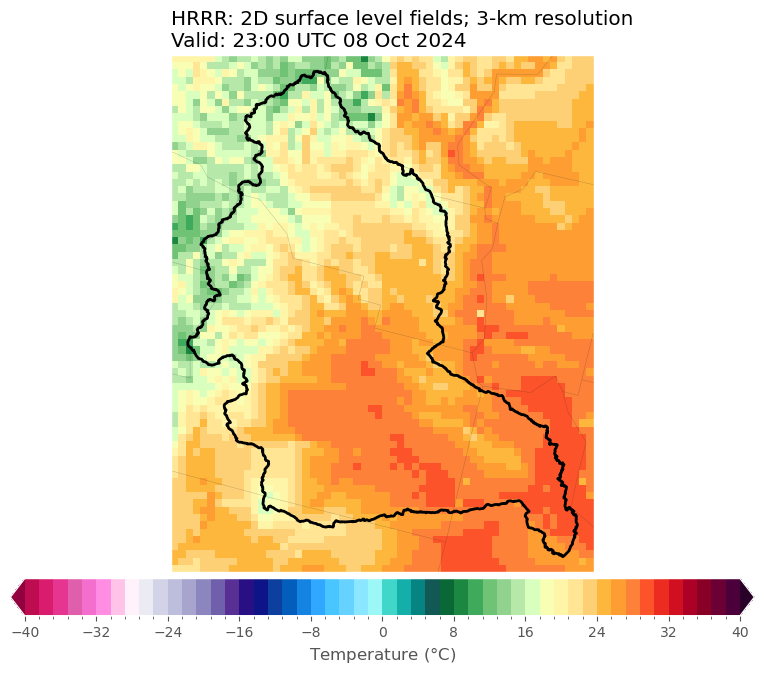

In [33]:
ax = EasyMap("50m", crs=t.herbie.crs, figsize=(12, 8)).STATES().OCEAN().LAND().COUNTIES().ax

p = ax.pcolormesh(
    yrb(t.longitude),
    yrb(t.latitude),
    yrb(t.t)-273.15,
    transform=pc,
    **cm_tmp(units="C", vmin=-40, vmax=40).cmap_kwargs,
)
plt.colorbar(
    p,
    ax=ax,
    orientation="horizontal",
    pad=0.01,
    shrink=0.8,
    **cm_tmp(units="C", vmin=-40, vmax=40).cbar_kwargs,
)

ax.set_title(
    f"{t.model.upper()}: {H.product_description}\nValid: {t.valid_time.dt.strftime('%H:%M UTC %d %b %Y').item()}",
    loc="left",
)
# ax.set_title(t.t.GRIB_name, loc="right")

ax.plot(yrb_wbd[:,0]+360, yrb_wbd[:,1], 'k', lw=2, transform=pc)

### Temperature (soil)

In [ ]:
st = H.xarray(":TSOIL:0-0 m below ground:"+postfix, remove_grib=False)

#### CONUS

In [ ]:
ax = EasyMap("50m", crs=st.herbie.crs, figsize=(12, 8)).STATES().OCEAN().LAND().COUNTIES().ax

p = ax.pcolormesh(
    st.longitude,
    st.latitude,
    st.st-273.15,
    transform=pc,
    **cm_tmp(units="C", vmin=-40, vmax=40).cmap_kwargs,
)
plt.colorbar(
    p,
    ax=ax,
    orientation="horizontal",
    pad=0.01,
    shrink=0.8,
    **cm_tmp(units="C", vmin=-40, vmax=40).cbar_kwargs,
)

ax.set_title(
    f"{st.model.upper()}: {H.product_description}\nValid: {st.valid_time.dt.strftime('%H:%M UTC %d %b %Y').item()}",
    loc="left",
)
ax.set_title(st.st.GRIB_name, loc="right")

#### Washington and YRB

In [ ]:
ax = EasyMap("50m", crs=st.herbie.crs, figsize=(12, 8)).STATES().OCEAN().LAND().COUNTIES().ax

p = ax.pcolormesh(
    wa(st.longitude),
    wa(st.latitude),
    wa(st.st)-273.15,
    transform=pc,
    **cm_tmp(units="C", vmin=-40, vmax=40).cmap_kwargs,
)
plt.colorbar(
    p,
    ax=ax,
    orientation="horizontal",
    pad=0.01,
    shrink=0.8,
    **cm_tmp(units="C", vmin=-40, vmax=40).cbar_kwargs,
)

ax.set_title(
    f"{st.model.upper()}: {H.product_description}\nValid: {st.valid_time.dt.strftime('%H:%M UTC %d %b %Y').item()}",
    loc="left",
)
ax.set_title(st.st.GRIB_name, loc="right")

In [ ]:
ax = EasyMap("50m", crs=st.herbie.crs, figsize=(12, 8)).STATES().OCEAN().LAND().COUNTIES().ax

p = ax.pcolormesh(
    yrb(st.longitude),
    yrb(st.latitude),
    yrb(st.st)-273.15,
    transform=pc,
    **cm_tmp(units="C", vmin=-40, vmax=40).cmap_kwargs,
)
plt.colorbar(
    p,
    ax=ax,
    orientation="horizontal",
    pad=0.01,
    shrink=0.8,
    **cm_tmp(units="C", vmin=-40, vmax=40).cbar_kwargs,
)

ax.set_title(
    f"{st.model.upper()}: {H.product_description}\nValid: {st.valid_time.dt.strftime('%H:%M UTC %d %b %Y').item()}",
    loc="left",
)
# ax.set_title(st.st.GRIB_name, loc="right")

ax.plot(yrb_wbd[:,0]+360, yrb_wbd[:,1], 'k', lw=2, transform=pc)

### Temperature difference between soil and 2 m above ground

#### CONUS

In [ ]:
ax = EasyMap("50m", crs=t.herbie.crs, figsize=(12, 8)).STATES().OCEAN().LAND().COUNTIES().ax

p = ax.pcolormesh(
    t.longitude,
    t.latitude,
    t2m.t2m - st.st,
    transform=pc,
    **cm_tmp(units="C", vmin=-10, vmax=10).cmap_kwargs,
)
plt.colorbar(
    p,
    ax=ax,
    orientation="horizontal",
    pad=0.01,
    shrink=0.8,
    **cm_tmp(units="C", vmin=-10, vmax=10).cbar_kwargs,
)

ax.set_title(
    f"{t.model.upper()}: {H.product_description}\nValid: {t.valid_time.dt.strftime('%H:%M UTC %d %b %Y').item()}",
    loc="left",
)
ax.set_title('Temperature difference', loc="right")

#### Washington and YRB

In [ ]:
ax = EasyMap("50m", crs=t.herbie.crs, figsize=(12, 8)).STATES().OCEAN().LAND().COUNTIES().ax

p = ax.pcolormesh(
    wa(t.longitude),
    wa(t.latitude),
    wa(t2m.t2m) - wa(st.st),
    transform=pc,
    **cm_tmp(units="C", vmin=-10, vmax=10).cmap_kwargs,
)
plt.colorbar(
    p,
    ax=ax,
    orientation="horizontal",
    pad=0.01,
    shrink=0.8,
    **cm_tmp(units="C", vmin=-10, vmax=10).cbar_kwargs,
)

ax.set_title(
    f"{t.model.upper()}: {H.product_description}\nValid: {t.valid_time.dt.strftime('%H:%M UTC %d %b %Y').item()}",
    loc="left",
)
ax.set_title('Temperature difference', loc="right")

In [ ]:
ax = EasyMap("50m", crs=t.herbie.crs, figsize=(12, 8)).STATES().OCEAN().LAND().COUNTIES().ax

p = ax.pcolormesh(
    yrb(t.longitude),
    yrb(t.latitude),
    yrb(t2m.t2m) - yrb(st.st),
    transform=pc,
    **cm_tmp(units="C", vmin=-10, vmax=10).cmap_kwargs,
)
plt.colorbar(
    p,
    ax=ax,
    orientation="horizontal",
    pad=0.01,
    shrink=0.8,
    **cm_tmp(units="C", vmin=-10, vmax=10).cbar_kwargs,
)

ax.set_title(
    f"{t.model.upper()}: {H.product_description}\nValid: {t.valid_time.dt.strftime('%H:%M UTC %d %b %Y').item()}",
    loc="left",
)
# ax.set_title('Temperature difference', loc="right")

ax.plot(yrb_wbd[:,0]+360, yrb_wbd[:,1], 'k', lw=2, transform=pc)

### Total precipitation

In [ ]:
d = H.xarray(f":APCP:surface:0-{forecast} {'hour' if forecast else 'day'} acc fcst", remove_grib=False)
d["tp"] = d.tp.where(d.tp != 0)

#### CONUS

In [ ]:
ax = EasyMap("50m", crs=d.herbie.crs, figsize=(12, 8)).STATES().OCEAN().LAND().COUNTIES().ax

p = ax.pcolormesh(
    d.longitude,
    d.latitude,
    d.tp,
    transform=pc,
    **cm_pcp(units='in').cmap_kwargs,
)
plt.colorbar(
    p,
    ax=ax,
    orientation="horizontal",
    pad=0.01,
    shrink=0.8,
    **cm_pcp(units='in').cbar_kwargs,
)

ax.set_title(
    f"{d.model.upper()}: {H.product_description}\nValid: {d.valid_time.dt.strftime('%H:%M UTC %d %b %Y').item()}",
    loc="left",
)
ax.set_title(d.tp.GRIB_name, loc="right")

#### Washington and YRB

In [ ]:
ax = EasyMap("50m", crs=d.herbie.crs, figsize=(12, 8)).STATES().OCEAN().LAND().COUNTIES().ax

p = ax.pcolormesh(
    wa(d.longitude),
    wa(d.latitude),
    wa(d.tp),
    transform=pc,
    **cm_pcp(units='in').cmap_kwargs,
)
plt.colorbar(
    p,
    ax=ax,
    orientation="horizontal",
    pad=0.01,
    shrink=0.8,
    **cm_pcp(units='in').cbar_kwargs,
)

ax.set_title(
    f"{d.model.upper()}: {H.product_description}\nValid: {d.valid_time.dt.strftime('%H:%M UTC %d %b %Y').item()}",
    loc="left",
)
ax.set_title(d.tp.GRIB_name, loc="right")

In [ ]:
ax = EasyMap("50m", crs=d.herbie.crs, figsize=(12, 8)).STATES().OCEAN().LAND().COUNTIES().ax

p = ax.pcolormesh(
    yrb(d.longitude),
    yrb(d.latitude),
    yrb(d.tp),
    transform=pc,
    **cm_pcp(units='in').cmap_kwargs,
)
plt.colorbar(
    p,
    ax=ax,
    orientation="horizontal",
    pad=0.01,
    shrink=0.8,
    **cm_pcp(units='in').cbar_kwargs,
)

ax.set_title(
    f"{d.model.upper()}: {H.product_description}\nValid: {d.valid_time.dt.strftime('%H:%M UTC %d %b %Y').item()}",
    loc="left",
)
# ax.set_title(d.tp.GRIB_name, loc="right")

ax.plot(yrb_wbd[:,0]+360, yrb_wbd[:,1], 'k', lw=2, transform=pc)

### Precipitation rate

In [ ]:
# d = H.xarray(f":PRATE:surface:{forecast} {'hour' if forecast else 'day'} fcst", remove_grib=False)
d = H.xarray(f":PRATE:surface:"+postfix, remove_grib=False)
d["prate"] = d.prate.where(d.prate != 0)
d["prate"] *= 86400 # km/m2/s = mm/s to mm/day 

#### CONUS

In [ ]:
ax = EasyMap("50m", crs=d.herbie.crs, figsize=(12, 8)).STATES().OCEAN().LAND().COUNTIES().ax

p = ax.pcolormesh(
    d.longitude,
    d.latitude,
    d.prate,
    transform=pc,
    vmin=0,
    vmax=120,
    cmap='turbo',
    # **cm_pcp(units='in').cmap_kwargs,
)
plt.colorbar(
    p,
    ax=ax,
    orientation="horizontal",
    pad=0.01,
    shrink=0.8,
    extend='max',
    # **cm_pcp(units='in').cbar_kwargs,
).ax.set_xlabel(d.prate.GRIB_name+' (mm/day)')

ax.set_title(
    f"{d.model.upper()}: {H.product_description}\nValid: {d.valid_time.dt.strftime('%H:%M UTC %d %b %Y').item()}",
    loc="left",
)
ax.set_title(d.prate.GRIB_name, loc="right")

#### Washington and YRB

In [ ]:
ax = EasyMap("50m", crs=d.herbie.crs, figsize=(12, 8)).STATES().OCEAN().LAND().COUNTIES().ax

p = ax.pcolormesh(
    wa(d.longitude),
    wa(d.latitude),
    wa(d.prate),
    transform=pc,
    vmin=0,
    vmax=120,
    cmap='turbo',
    # **cm_pcp(units='in').cmap_kwargs,
)
plt.colorbar(
    p,
    ax=ax,
    orientation="horizontal",
    pad=0.01,
    shrink=0.8,
    extend='max',
    # **cm_pcp(units='in').cbar_kwargs,
).ax.set_xlabel(d.prate.GRIB_name+' (mm/day)')

ax.set_title(
    f"{d.model.upper()}: {H.product_description}\nValid: {d.valid_time.dt.strftime('%H:%M UTC %d %b %Y').item()}",
    loc="left",
)
ax.set_title(d.prate.GRIB_name, loc="right")

In [ ]:
ax = EasyMap("50m", crs=d.herbie.crs, figsize=(12, 8)).STATES().OCEAN().LAND().COUNTIES().ax

p = ax.pcolormesh(
    yrb(d.longitude),
    yrb(d.latitude),
    yrb(d.prate),
    transform=pc,
    vmin=0,
    vmax=120,
    cmap='turbo',
    # **cm_pcp(units='in').cmap_kwargs,
)
plt.colorbar(
    p,
    ax=ax,
    orientation="horizontal",
    pad=0.01,
    shrink=0.8,
    extend='max',
    # **cm_pcp(units='in').cbar_kwargs,
).ax.set_xlabel(d.prate.GRIB_name+' (mm/day)')

ax.set_title(
    f"{d.model.upper()}: {H.product_description}\nValid: {d.valid_time.dt.strftime('%H:%M UTC %d %b %Y').item()}",
    loc="left",
)
# ax.set_title(d.prate.GRIB_name, loc="right")
ax.plot(yrb_wbd[:,0]+360, yrb_wbd[:,1], 'k', lw=2, transform=pc)

### Relative humidity 2 m above ground

In [ ]:
d = H.xarray(":RH:2 m above ground:"+postfix, remove_grib=False)

#### CONUS

In [ ]:
ax = EasyMap("50m", crs=d.herbie.crs, figsize=(12, 8)).STATES().OCEAN().LAND().COUNTIES().ax

p = ax.pcolormesh(
    d.longitude,
    d.latitude,
    d.r2,
    transform=pc,
    **cm_rh().cmap_kwargs,
)
plt.colorbar(
    p,
    ax=ax,
    orientation="horizontal",
    pad=0.01,
    shrink=0.8,
    **cm_rh().cbar_kwargs,
)

ax.set_title(
    f"{d.model.upper()}: {H.product_description}\nValid: {d.valid_time.dt.strftime('%H:%M UTC %d %b %Y').item()}",
    loc="left",
)
ax.set_title(d.r2.GRIB_name, loc="right")

#### Washington and YRB

In [ ]:
ax = EasyMap("50m", crs=d.herbie.crs, figsize=(12, 8)).STATES().OCEAN().LAND().COUNTIES().ax

p = ax.pcolormesh(
    wa(d.longitude),
    wa(d.latitude),
    wa(d.r2),
    transform=pc,
    **cm_rh().cmap_kwargs,
)
plt.colorbar(
    p,
    ax=ax,
    orientation="horizontal",
    pad=0.01,
    shrink=0.8,
    **cm_rh().cbar_kwargs,
)

ax.set_title(
    f"{d.model.upper()}: {H.product_description}\nValid: {d.valid_time.dt.strftime('%H:%M UTC %d %b %Y').item()}",
    loc="left",
)
ax.set_title(d.r2.GRIB_name, loc="right")

In [ ]:
ax = EasyMap("50m", crs=d.herbie.crs, figsize=(12, 8)).STATES().OCEAN().LAND().COUNTIES().ax

p = ax.pcolormesh(
    yrb(d.longitude),
    yrb(d.latitude),
    yrb(d.r2),
    transform=pc,
    **cm_rh().cmap_kwargs,
)
plt.colorbar(
    p,
    ax=ax,
    orientation="horizontal",
    pad=0.01,
    shrink=0.8,
    **cm_rh().cbar_kwargs,
)

ax.set_title(
    f"{d.model.upper()}: {H.product_description}\nValid: {d.valid_time.dt.strftime('%H:%M UTC %d %b %Y').item()}",
    loc="left",
)
# ax.set_title(d.r2.GRIB_name, loc="right")

ax.plot(yrb_wbd[:,0]+360, yrb_wbd[:,1], 'k', lw=2, transform=pc)

### Vapor pressure 2 m above ground

In [ ]:
vp = d.r2.values/100*611.2*np.exp(17.67*(t2m.t2m.values-273.15)/(t2m.t2m.values-273.15+243.5))
vp[vp == 0] = np.nan

#### CONUS

In [ ]:
ax = EasyMap("50m", crs=d.herbie.crs, figsize=(12, 8)).STATES().OCEAN().LAND().COUNTIES().ax

p = ax.pcolormesh(
    d.longitude,
    d.latitude,
    vp,
    transform=pc,
    vmin=0,
    vmax=1000,
    cmap='RdYlBu_r',
    # **cm_rh().cmap_kwargs,
)
plt.colorbar(
    p,
    ax=ax,
    orientation="horizontal",
    pad=0.01,
    shrink=0.8,
    extend='max',
    # **cm_rh().cbar_kwargs,
).ax.set_xlabel('Vapor Pressure (Pa)')

ax.set_title(
    f"{d.model.upper()}: {H.product_description}\nValid: {d.valid_time.dt.strftime('%H:%M UTC %d %b %Y').item()}",
    loc="left",
)
ax.set_title('Vapor Pressure', loc="right")

#### Washington and YRB

In [ ]:
ax = EasyMap("50m", crs=d.herbie.crs, figsize=(12, 8)).STATES().OCEAN().LAND().COUNTIES().ax

p = ax.pcolormesh(
    wa(d.longitude),
    wa(d.latitude) ,
    wa(vp),
    transform=pc,
    vmin=0,
    vmax=1000,
    cmap='RdYlBu_r',
    # **cm_rh().cmap_kwargs,
)
plt.colorbar(
    p,
    ax=ax,
    orientation="horizontal",
    pad=0.01,
    shrink=0.8,
    extend='max',
    # **cm_rh().cbar_kwargs,
).ax.set_xlabel('Vapor Pressure (Pa)')

ax.set_title(
    f"{d.model.upper()}: {H.product_description}\nValid: {d.valid_time.dt.strftime('%H:%M UTC %d %b %Y').item()}",
    loc="left",
)
ax.set_title('Vapor Pressure', loc="right")

ax.plot(yrb_wbd[:,0]+360, yrb_wbd[:,1], 'k', lw=2, transform=pc)

In [ ]:
ax = EasyMap("50m", crs=d.herbie.crs, figsize=(12, 8)).STATES().OCEAN().LAND().COUNTIES().ax

p = ax.pcolormesh(
    yrb(d.longitude),
    yrb(d.latitude) ,
    yrb(vp),
    transform=pc,
    vmin=0,
    vmax=1000,
    cmap='RdYlBu_r',
    # **cm_rh().cmap_kwargs,
)
plt.colorbar(
    p,
    ax=ax,
    orientation="horizontal",
    pad=0.01,
    shrink=0.8,
    extend='max',
    # **cm_rh().cbar_kwargs,
).ax.set_xlabel('Vapor Pressure (Pa)')

ax.set_title(
    f"{d.model.upper()}: {H.product_description}\nValid: {d.valid_time.dt.strftime('%H:%M UTC %d %b %Y').item()}",
    loc="left",
)
# ax.set_title('Vapor Pressure', loc="right")

ax.plot(yrb_wbd[:,0]+360, yrb_wbd[:,1], 'k', lw=2, transform=pc)

### Downward short-wave radiation flux

In [ ]:
d = H.xarray(":DSWRF:surface:"+postfix, remove_grib=False)
d["dswrf"] = d.dswrf.where(d.dswrf != 0)

#### CONUS

In [ ]:
ax = EasyMap("50m", crs=t.herbie.crs, figsize=(12, 8)).STATES().OCEAN().LAND().COUNTIES().ax

p = ax.pcolormesh(
    d.longitude,
    d.latitude,
    d.dswrf,
    transform=pc,
    vmin=0,
    vmax=1000,
    cmap='Spectral_r'
    # **cm_rh(vmin=0, vmax=200).cmap_kwargs,
)
plt.colorbar(
    p,
    ax=ax,
    orientation="horizontal",
    pad=0.01,
    shrink=0.8,
    # **cm_rh(vmin=0, vmax=200).cbar_kwargs,
).ax.set_xlabel(d.dswrf.GRIB_name+' (W/m2)')

ax.set_title(
    f"{d.model.upper()}: {H.product_description}\nValid: {d.valid_time.dt.strftime('%H:%M UTC %d %b %Y').item()}",
    loc="left",
)
ax.set_title(d.dswrf.GRIB_name, loc="right")

#### Washington and YRB

In [ ]:
ax = EasyMap("50m", crs=t.herbie.crs, figsize=(12, 8)).STATES().OCEAN().LAND().COUNTIES().ax

p = ax.pcolormesh(
    wa(d.longitude),
    wa(d.latitude),
    wa(d.dswrf),
    transform=pc,
    vmin=0,
    vmax=1000,
    cmap='Spectral_r'
    # **cm_rh(vmin=0, vmax=200).cmap_kwargs,
)
plt.colorbar(
    p,
    ax=ax,
    orientation="horizontal",
    pad=0.01,
    shrink=0.8,
    # **cm_rh(vmin=0, vmax=200).cbar_kwargs,
).ax.set_xlabel(d.dswrf.GRIB_name+' (W/m2)')

ax.set_title(
    f"{d.model.upper()}: {H.product_description}\nValid: {d.valid_time.dt.strftime('%H:%M UTC %d %b %Y').item()}",
    loc="left",
)
ax.set_title(d.dswrf.GRIB_name, loc="right")

In [ ]:
ax = EasyMap("50m", crs=t.herbie.crs, figsize=(12, 8)).STATES().OCEAN().LAND().COUNTIES().ax

p = ax.pcolormesh(
    yrb(d.longitude),
    yrb(d.latitude),
    yrb(d.dswrf),
    transform=pc,
    vmin=0,
    vmax=1000,
    cmap='Spectral_r'
    # **cm_rh(vmin=0, vmax=200).cmap_kwargs,
)
plt.colorbar(
    p,
    ax=ax,
    orientation="horizontal",
    pad=0.01,
    shrink=0.8,
    # **cm_rh(vmin=0, vmax=200).cbar_kwargs,
).ax.set_xlabel(d.dswrf.GRIB_name+' (W/m2)')

ax.set_title(
    f"{d.model.upper()}: {H.product_description}\nValid: {d.valid_time.dt.strftime('%H:%M UTC %d %b %Y').item()}",
    loc="left",
)
# ax.set_title(d.dswrf.GRIB_name, loc="right")

ax.plot(yrb_wbd[:,0]+360, yrb_wbd[:,1], 'k', lw=2, transform=pc)

### Volumetric soil moisture content 1cm below ground [-]

In [ ]:
soilw = H.xarray(":SOILW:0.01-0.01 m below ground:"+postfix, remove_grib=False)

#### CONUS

In [ ]:
ax = EasyMap("50m", crs=soilw.herbie.crs, figsize=(12, 8)).STATES().OCEAN().LAND().COUNTIES().ax

p = ax.pcolormesh(
    soilw.longitude,
    soilw.latitude,
    soilw.soilw,
    transform=pc,
    vmin=0.1,
    vmax=0.4,
    cmap='Spectral',
    # **cm_pcp(units='in').cmap_kwargs,
)
plt.colorbar(
    p,
    ax=ax,
    orientation="horizontal",
    pad=0.01,
    shrink=0.8,
    extend='both',
    # **cm_pcp(units='in').cbar_kwargs,
).ax.set_xlabel('volumetric soil moisture content [-]')

ax.set_title("volumetric soil moisture content [-]")
plt.show()

#### Washington and YRB

In [ ]:
ax = EasyMap("50m", crs=soilw.herbie.crs, figsize=(12, 8)).STATES().OCEAN().LAND().COUNTIES().ax

p = ax.pcolormesh(
    wa(soilw.longitude),
    wa(soilw.latitude),
    wa(soilw.soilw),
    transform=pc,
    vmin=0.1,
    vmax=0.4,
    cmap='Spectral',
    # **cm_pcp(units='in').cmap_kwargs,
)
plt.colorbar(
    p,
    ax=ax,
    orientation="horizontal",
    pad=0.01,
    shrink=0.8,
    extend='max',
    # **cm_pcp(units='in').cbar_kwargs,
).ax.set_xlabel('volumetric soil moisture content [-]')

ax.set_title("volumetric soil moisture content [-]")

In [ ]:
ax = EasyMap("50m", crs=soilw.herbie.crs, figsize=(12, 8)).STATES().OCEAN().LAND().COUNTIES().ax

p = ax.pcolormesh(
    yrb(soilw.longitude),
    yrb(soilw.latitude),
    yrb(soilw.soilw),
    transform=pc,
    vmin=0.1,
    vmax=0.4,
    cmap='Spectral',
    # **cm_pcp(units='in').cmap_kwargs,
)
plt.colorbar(
    p,
    ax=ax,
    orientation="horizontal",
    pad=0.01,
    shrink=0.8,
    extend='max',
    # **cm_pcp(units='in').cbar_kwargs,
).ax.set_xlabel('volumetric soil moisture content [-]')

ax.set_title("volumetric soil moisture content [-]")
ax.plot(yrb_wbd[:,0]+360, yrb_wbd[:,1], 'k', lw=2, transform=pc)

### Leaf area index

In [ ]:
H = Herbie(time, model="hrrr", product="sfc", fxx=forecast)
lai = H.xarray(":LAI:surface:"+postfix, remove_grib=False)
lai["lai"] = lai.lai.where(lai.lai != 0)

#### CONUS

In [ ]:
ax = EasyMap("50m", crs=lai.herbie.crs, figsize=(12, 8)).STATES().OCEAN().LAND().COUNTIES().ax

p = ax.pcolormesh(
    lai.longitude,
    lai.latitude,
    lai.lai,
    transform=pc,
    vmin=0,
    vmax=5,
    cmap='BrBG',
    # **cm_tmp(units="C", vmin=-40, vmax=40).cmap_kwargs,
)
plt.colorbar(
    p,
    ax=ax,
    orientation="horizontal",
    pad=0.01,
    shrink=0.8,
    extend='max',
    # **cm_tmp(units="C", vmin=-40, vmax=40).cbar_kwargs,
).ax.set_xlabel(lai.lai.GRIB_name+' (m2/m2)')

ax.set_title(
    f"{lai.model.upper()}: {H.product_description}\nValid: {lai.valid_time.dt.strftime('%H:%M UTC %d %b %Y').item()}",
    loc="left",
)
ax.set_title(lai.lai.GRIB_name, loc="right")

#### Washington and YRB

In [ ]:
ax = EasyMap("50m", crs=lai.herbie.crs, figsize=(12, 8)).STATES().OCEAN().LAND().COUNTIES().ax

p = ax.pcolormesh(
    wa(lai.longitude),
    wa(lai.latitude),
    wa(lai.lai),
    transform=pc,
    vmin=0,
    vmax=5,
    cmap='BrBG', 
    # **cm_tmp(units="C", vmin=-40, vmax=40).cmap_kwargs,
)
plt.colorbar(
    p,
    ax=ax,
    orientation="horizontal",
    pad=0.01,
    shrink=0.8,
    extend='max',
    # **cm_tmp(units="C", vmin=-40, vmax=40).cbar_kwargs,
).ax.set_xlabel(lai.lai.GRIB_name+' (m2/m2)')

ax.set_title(
    f"{lai.model.upper()}: {H.product_description}\nValid: {lai.valid_time.dt.strftime('%H:%M UTC %d %b %Y').item()}",
    loc="left",
)
ax.set_title(lai.lai.GRIB_name, loc="right")

In [ ]:
ax = EasyMap("50m", crs=lai.herbie.crs, figsize=(12, 8)).STATES().OCEAN().LAND().COUNTIES().ax

p = ax.pcolormesh(
    yrb(lai.longitude),
    yrb(lai.latitude),
    yrb(lai.lai),
    transform=pc,
    vmin=0,
    vmax=5,
    cmap='BrBG',
    # **cm_tmp(units="C", vmin=-40, vmax=40).cmap_kwargs,
)
plt.colorbar(
    p,
    ax=ax,
    orientation="horizontal",
    pad=0.01,
    shrink=0.8,
    extend='max',
    # **cm_tmp(units="C", vmin=-40, vmax=40).cbar_kwargs,
).ax.set_xlabel(lai.lai.GRIB_name+' (m2/m2)')

ax.set_title(
    f"{lai.model.upper()}: {H.product_description}\nValid: {lai.valid_time.dt.strftime('%H:%M UTC %d %b %Y').item()}",
    loc="left",
)
# ax.set_title(lai.lai.GRIB_name, loc="right")

ax.plot(yrb_wbd[:,0]+360, yrb_wbd[:,1], 'k', lw=2, transform=pc)

# Get hourly animation

In [46]:
try:
    os.mkdir('./figs/')
except FileExistsError:
    pass

In [49]:
year = 2024
month = 9
day = 23
number_of_days = 15

In [ ]:
times = pd.date_range(f'{year}-{month}-{day} 00:00:00', periods=int(24*number_of_days), freq="1H")
times

In [51]:
forecast = 1
if forecast:
    postfix = f'{forecast} hour fcst'
else:
    postfix = 'anl'

In [ ]:
# temperature
for i, time in tqdm(enumerate(times)):
    H = Herbie(time, model="hrrr", product="sfc", fxx=forecast, verbose=False)
    t2m = H.xarray(":TMP:2 m above ground:"+postfix, remove_grib=False)

    ax = EasyMap("50m", crs=t2m.herbie.crs, figsize=(12, 8)).STATES().OCEAN().LAND().COUNTIES().ax

    p = ax.pcolormesh(
        t2m.longitude,
        t2m.latitude,
        t2m.t2m-273.15,
        transform=pc,
        **cm_tmp(units="C", vmin=-40, vmax=40).cmap_kwargs,
    )
    plt.colorbar(
        p,
        ax=ax,
        orientation="horizontal",
        pad=0.01,
        shrink=0.8,
        **cm_tmp(units="C", vmin=-40, vmax=40).cbar_kwargs,
    )

    ax.set_title(
        f"{t2m.model.upper()}: {H.product_description}\nValid: {t2m.valid_time.dt.strftime('%H:%M UTC %d %b %Y').item()}",
        loc="left",
    )
    ax.set_title(t2m.t2m.GRIB_name, loc="right")
    plt.savefig(f'./figs/'+str(i).zfill(4)+'.jpg', dpi=150)
    plt.close()

In [ ]:
# temperature
for i, time in tqdm(enumerate(times)):
    H = Herbie(time, model="hrrr", product="sfc", fxx=forecast, verbose=False)
    t2m = H.xarray(":TMP:2 m above ground:"+postfix, remove_grib=False)

    ax = EasyMap("50m", crs=t2m.herbie.crs, figsize=(12, 8)).STATES().OCEAN().LAND().COUNTIES().ax

    p = ax.pcolormesh(
        yrb(t2m.longitude),
        yrb(t2m.latitude),
        yrb(t2m.t2m)-273.15,
        transform=pc,
        **cm_tmp(units="C", vmin=-40, vmax=40).cmap_kwargs,
    )
    plt.colorbar(
        p,
        ax=ax,
        orientation="horizontal",
        pad=0.01,
        shrink=0.8,
        **cm_tmp(units="C", vmin=-40, vmax=40).cbar_kwargs,
    )

    ax.set_title(
        f"{t2m.model.upper()}: {H.product_description}\nValid: {t2m.valid_time.dt.strftime('%H:%M UTC %d %b %Y').item()}",
        loc="left",
    )
    # ax.set_title(t2m.t2m.GRIB_name, loc="right")
    ax.plot(yrb_wbd[:,0]+360, yrb_wbd[:,1], 'k', lw=2, transform=pc)
    plt.savefig(f'./figs/'+str(i).zfill(4)+'.jpg', dpi=150)
    plt.close()

In [58]:
# # LAI
# for i, time in tqdm(enumerate(times)):
#     H = Herbie(time, model="hrrr", product="sfc", fxx=forecast, verbose=False)
#     lai = H.xarray(":LAI:surface:"+postfix, remove_grib=False)
#     # lai["lai"] = lai.lai.where(lai.lai != 0)

#     ax = EasyMap("50m", crs=lai.herbie.crs, figsize=(12, 8)).STATES().OCEAN().LAND().COUNTIES().ax

#     p = ax.pcolormesh(
#         yrb(lai.longitude),
#         yrb(lai.latitude),
#         yrb(lai.lai),
#         transform=pc,
#         vmin=0,
#         vmax=3,
#         cmap='BrBG',
#         # **cm_tmp(units="C", vmin=-40, vmax=40).cmap_kwargs,
#     )
#     plt.colorbar(
#         p,
#         ax=ax,
#         orientation="horizontal",
#         pad=0.01,
#         shrink=0.8,
#         extend='max',
#         # **cm_tmp(units="C", vmin=-40, vmax=40).cbar_kwargs,
#     ).ax.set_xlabel(lai.lai.GRIB_name+' (m2/m2)')

#     ax.set_title(
#         f"{lai.model.upper()}: {H.product_description}\nValid: {lai.valid_time.dt.strftime('%H:%M UTC %d %b %Y').item()}",
#         loc="left",
#     )
#     # ax.set_title(lai.lai.GRIB_name, loc="right")
#     ax.plot(yrb_wbd[:,0]+360, yrb_wbd[:,1], 'k', lw=2, transform=pc)
#     plt.savefig(f'./figs/'+str(i).zfill(4)+'.jpg', dpi=150)
#     plt.close()

In [59]:
from makegif import make_gif

In [ ]:
make_gif('figs', fps=60)
# os.system("ffmpeg -pattern_type glob -i './figs/*.jpg' -r 90 video.avi")

# Get hourly data

## Read Daymet hdf5

In [61]:
def read_daymet_h5(filename):
    data = {}
    attrs = {}
    with h5py.File(filename, 'r') as f:
        for k, v in f.items():
            try:
                data[k] = v[:]
            except TypeError:
                data_t = {}
                for tk, tv in v.items():
                    data_t[tk] = tv[:]
                data[k] = data_t
        for k, v in f.attrs.items():
            attrs[k] = v
    return data, attrs

In [ ]:
data, attrs = read_daymet_h5(os.path.join(os.environ.get('SCRATCH'), 'Naches/data-processed/Naches', 'Naches_DayMet_1980_2023.h5'))

In [ ]:
keys = data.keys()
for key in keys:
    print(key, type(data[key]))
    if isinstance(data[key], dict):
        _keys = data[key].keys()
        for _key in _keys:
            if int(_key) > 1:
                break
            print('\t', _key, ':', data[key][_key].shape, type(data[key][_key]))

In [ ]:
attrs

In [ ]:
data["x [m]"].shape, data["y [m]"].shape, data["air temperature [K]"]["0"].shape

## Create HRRR hdf5

In [63]:
data = {
    "air temperature [K]": {},
    "soil temperature [K]": {},
    "incoming shortwave radiation [W m^-2]": {},
    "precipitation [m s^-1]": {},
    "precipitation rain [m s^-1]": {},
    "precipitation snow [m SWE s^-1]": {},
    "vapor pressure air [Pa]": {},
    "leaf area index [-]": {},
    "volumetric soil moisture content [-]": {},
    "time [s]": np.empty(0),
    "x [m]": np.empty(0),
    "y [m]": np.empty(0),
}

In [64]:
keys = data.keys()
for key in keys:
    print(key, type(data[key]))
    if isinstance(data[key], dict):
        _keys = data[key].keys()
        for _key in _keys:
            if int(_key) > 1:
                break
            print('\t', _key, ': type is', type(data[key][_key]))

air temperature [K] <class 'dict'>
soil temperature [K] <class 'dict'>
incoming shortwave radiation [W m^-2] <class 'dict'>
precipitation [m s^-1] <class 'dict'>
precipitation rain [m s^-1] <class 'dict'>
precipitation snow [m SWE s^-1] <class 'dict'>
vapor pressure air [Pa] <class 'dict'>
leaf area index [-] <class 'dict'>
volumetric soil moisture content [-] <class 'dict'>
time [s] <class 'numpy.ndarray'>
x [m] <class 'numpy.ndarray'>
y [m] <class 'numpy.ndarray'>


In [65]:
year = 2024
month = 1
day = 1
number_of_days = 275

In [ ]:
times = pd.date_range(f'{year}-{month}-{day} 06:00:00', periods=int(24*number_of_days), freq="1H")
times

In [67]:
forecast = 1
if forecast:
    postfix = f'{forecast} hour fcst'
else:
    postfix = 'anl'

In [ ]:
for i in trange(len(times)):
    H = Herbie(times[i], model="hrrr", product="prs", fxx=forecast, verbose=False)
    
    # Air temperature
    t2m = H.xarray(":TMP:2 m above ground:"+postfix, remove_grib=False)
    data["air temperature [K]"][str(i)] = yrb(t2m.t2m.values)
    
    # Precipitation rate
    prate = H.xarray(":PRATE:surface:"+postfix, remove_grib=False)
    prate["prate"] /= 1e3 # kg/m2/s = mm/s to m/s 
    data["precipitation [m s^-1]"][str(i)] = yrb(prate.prate.values)
    rain = np.where(t2m.t2m.values >= 273.15, prate.prate.values, 0)
    snow = np.where(t2m.t2m.values < 273.15, prate.prate.values, 0)
    data["precipitation rain [m s^-1]"][str(i)] = yrb(rain)
    data["precipitation snow [m SWE s^-1]"][str(i)] = yrb(snow)
    
    # Relative humidity to vapor pressure
    rh = H.xarray(":RH:2 m above ground:"+postfix, remove_grib=False)
    vp = rh.r2.values/100*611.2*np.exp(17.67*(t2m.t2m.values-273.15)/(t2m.t2m.values-273.15+243.5))
    data["vapor pressure air [Pa]"][str(i)] = yrb(vp)
    
    # Shortwave radiation
    srad = H.xarray(":DSWRF:surface:"+postfix, remove_grib=False)
    data["incoming shortwave radiation [W m^-2]"][str(i)] = yrb(srad.dswrf.values)
    
    # Soil temperature
    st = H.xarray(":TSOIL:0-0 m below ground:"+postfix, remove_grib=False)
    data["soil temperature [K]"][str(i)] = yrb(st.st.values)
    
    # Soil moisture
    soilw = H.xarray(":SOILW:0.01-0.01 m below ground:"+postfix, remove_grib=False)
    data["volumetric soil moisture content [-]"][str(i)] = yrb(soilw.soilw.values)
    
    # # Leaf area index
    # H = Herbie(times[0], model="hrrr", product="sfc", fxx=forecast, verbose=False)
    # lai = H.xarray(":LAI:surface:"+postfix, remove_grib=False)
    # data["leaf area index [-]"][str(i)] = yrb(lai.lai.values)

In [ ]:
rain = np.where(rain != 0, rain, np.nan)
ax = EasyMap("50m", crs=t2m.herbie.crs, figsize=(12, 8)).STATES().OCEAN().LAND().COUNTIES().ax

p = ax.pcolormesh(
    t2m.longitude,
    t2m.latitude,
    rain,
    transform=pc,
    vmin=0,
    vmax=1e-6,
    cmap='turbo',
    # **cm_pcp(units='in').cmap_kwargs,
)
plt.colorbar(
    p,
    ax=ax,
    orientation="horizontal",
    pad=0.01,
    shrink=0.8,
    extend='max',
    # **cm_pcp(units='in').cbar_kwargs,
).ax.set_xlabel('rain (m/s)')

ax.set_title("rain (m/s)")
plt.show()

In [ ]:
snow = np.where(snow != 0, snow, np.nan)
ax = EasyMap("50m", crs=t2m.herbie.crs, figsize=(12, 8)).STATES().OCEAN().LAND().COUNTIES().ax

p = ax.pcolormesh(
    t2m.longitude,
    t2m.latitude,
    snow,
    transform=pc,
    vmin=0,
    vmax=1e-6,
    cmap='turbo',
    # **cm_pcp(units='in').cmap_kwargs,
)
plt.colorbar(
    p,
    ax=ax,
    orientation="horizontal",
    pad=0.01,
    shrink=0.8,
    extend='max',
    # **cm_pcp(units='in').cbar_kwargs,
).ax.set_xlabel('snow (m/s)')

ax.set_title("snow (m/s)")
plt.show()

In [ ]:
raster_shape = yrb(t2m.longitude).values.shape
raster_shape

In [ ]:
xyz_daymet = np.loadtxt('./xyz_csv/xyz_daymet.xyz')
x_daymet, y_daymet = xyz_daymet[:, 0].reshape(raster_shape), xyz_daymet[:, 1].reshape(raster_shape)
x_daymet.shape, y_daymet.shape

In [ ]:
xv, yv = np.meshgrid(np.linspace(x_daymet.min(), x_daymet.max(), raster_shape[1]), np.linspace(y_daymet.min(), y_daymet.max(), raster_shape[0]))
xv.shape, yv.shape

In [ ]:
data["x [m]"], data["y [m]"] = xv[0, :], yv[:, 0]

In [ ]:
data["time [s]"] = (np.arange(int(number_of_days))+(year-1980)*365)*86400

In [ ]:
keys = data.keys()
for key in keys:
    print(key, type(data[key]))
    if isinstance(data[key], dict):
        _keys = data[key].keys()
        for _key in _keys:
            if int(_key) > 1:
                break
            print('\t', _key, ': type is', type(data[key][_key]))

In [ ]:
def write_daymet_h5(filename, data):#, attrs):
    with h5py.File(filename, 'w') as f:
        for k, v in data.items():
            try:
                f.create_dataset(k, data=v)
            except TypeError:
                g = f.create_group(k)
                for tk, tv in v.items():
                    g.create_dataset(tk, data=tv)
        # for k, v in attrs.items():
        #     f.attrs[k] = v

In [ ]:
write_daymet_h5(f'hrrr_{year}.h5', data)